# Demonstration of the MA code's ability to decode social information from song

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg, rand_string
from disp import set_plot, plot_b, colors
from my_stats import nanpearsonr

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

# Load natural song snippets

In [2]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [3]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [4]:
def get_snippets(T_SNP, MIN_GAP, MIN_POWER=0, MAX_POWER=1):
    # get snippets
    nt_snp = int(round(T_SNP*FPS))
    t_snp = np.arange(nt_snp)*DT

    snps = []

    # go through all songs
    for ctr, sng_full in enumerate(sngs_full):
        
        segs, bds = get_seg(sng_full > 0, min_gap=int(round(MIN_GAP/DT)))
        
        segs = [sng_full[lb:ub] for lb, ub in bds]
        
        # keep fixed-length portions only of sufficiently long segments
        segs = [
            seg[:nt_snp] for seg in segs
            if (len(seg) >= nt_snp)
            and (np.mean(seg[:nt_snp] > 0) > MIN_POWER)
            and (np.mean(seg[:nt_snp] > 0) < MAX_POWER)
        ]
        
        snps.extend(segs)

    snps = np.array(snps)
    nsnp = len(snps)

    i_ss = [(snp == 1).astype(float) for snp in snps]
    i_ps = [(snp == 2).astype(float) for snp in snps]
    
    return snps, i_ss, i_ps

In [5]:
def smlt(i_s, i_p, tau_r, tau_a, x_s, x_p, adapt='MA'):
    t = np.arange(len(i_s))*DT
    n = len(tau_a)
    
    vs = np.nan*np.zeros((len(t), n))
    vs[0, :] = 0
    
    rs = np.nan*np.zeros((len(t), n))
    rs[0, :] = 0
    
    a_ss = np.zeros((len(t), n))
    a_ps = np.zeros((len(t), n))
    
    for ct in range(1, len(t)):
        
        # update adapted input
        if adapt == 'MA':
            vs[ct, :] = x_s*(1-a_ss[ct-1, :])*i_s[ct] + x_p*(1-a_ps[ct-1, :])*i_p[ct]
        elif adapt == 'lin':
            vs[ct, :] = x_s*(i_s[ct]-a_ss[ct-1, :]) + x_p*(i_p[ct]-a_ps[ct-1, :])
        
        # update integral
        rs[ct, :] = rs[ct-1, :] + (DT/tau_r)*(-rs[ct-1, :] + vs[ct, :])
        
        # update adaptation variables
        a_ss[ct, :] = a_ss[ct-1, :] + (DT/tau_a)*(-a_ss[ct-1, :] + i_s[ct])
        a_ps[ct, :] = a_ps[ct-1, :] + (DT/tau_a)*(-a_ps[ct-1, :] + i_p[ct])
        
    return rs, vs, a_ss, a_ps, t

In [10]:
def get_basis(motif_basis, tau_r, tau_a, x_s, x_p, adapt, alpha):
    basis = np.nan*np.zeros((len(tau_r), len(motif_basis)))
    rs_full = []

    for cmotif, motif in enumerate(motif_basis):
        i_s = (motif == 1).astype(float)
        i_p = (motif == 2).astype(float)

        t_snp = np.arange(len(motif))*DT

        rs = smlt(i_s, i_p, tau_r, tau_a, x_s, x_p, adapt=adapt)[0]

        basis[:, cmotif] = rs[-1, :]
        rs_full.append(rs)
        
    rgr = linear_model.Ridge(alpha=alpha, fit_intercept=False)
    w_readout = rgr.fit(basis.T, np.eye(len(motif_basis))).coef_.T
    
    return basis, w_readout, rs_full

In [16]:
def make_rand_song(z, motif_basis, t_pause, t_total):
    
    pause = np.repeat(0, int(round(t_pause/DT)))
    
    sng_segs = [[]]
    t_motifs = []
    imotifs = []
    
    while len(cc(sng_segs))*DT < (t_total-t_pause):
        
        imotif = np.random.choice(range(len(z)), p=z/z.sum())
        
        motif = motif_basis[imotif]
        
        sng_segs.append(pause)
        sng_segs.append(motif)
        
        t_motifs.append(DT*(len(cc(sng_segs)) - len(motif)/2))
        imotifs.append(imotif)
    
    sng_segs.append(pause)
    sng = cc(sng_segs)
    t_sng = np.arange(len(sng))*DT
    
    return sng, t_sng, t_motifs, imotifs

In [17]:
N = 20
tau_r = np.random.uniform(120, 120, N)
tau_a = np.random.uniform(.1, 2, N)
x_s = np.random.uniform(0, 1, N)
x_p = np.random.uniform(0, 1, N)
# minh = np.random.rand(N) < .5
# x_s[minh] *= -1
# x_p[minh] *= -1

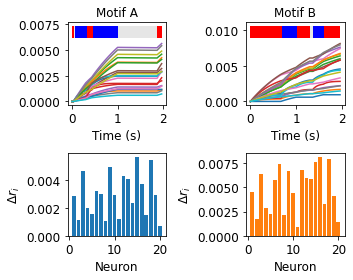

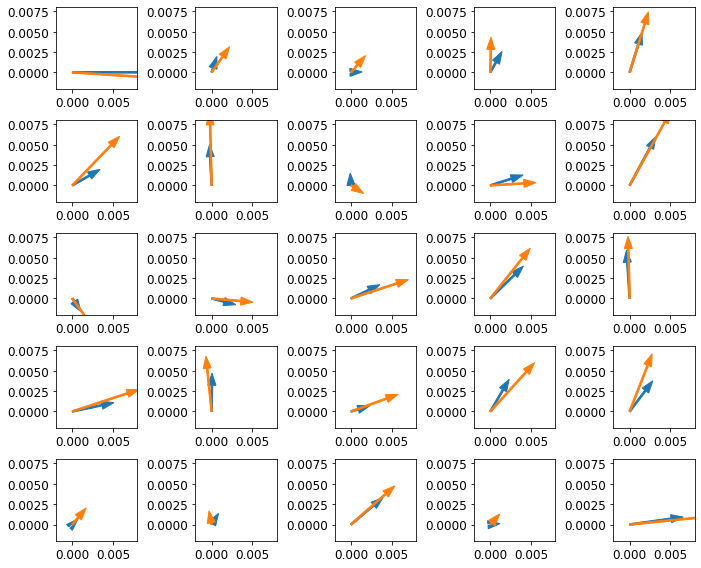

In [39]:
# snps, i_ss, i_ps = get_snippets(T_SNP=2, MIN_GAP=3, MIN_POWER=0.5)
# isnps = np.random.choice(range(len(snps)), 2, replace=False)
# chirp_basis = [snps[isnp] for isnp in isnps]

# use fixed example motif basis for demo
motif_basis = np.array([
    [2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
])

ALPHA = 1e-9
basis_ma, w_ma, rs_full_ma = get_basis(motif_basis, tau_r, tau_a, x_s, x_p, adapt='MA', alpha=ALPHA)
basis_lin, w_lin, rs_full_lin = get_basis(motif_basis, tau_r, tau_a, x_s, x_p, adapt='lin', alpha=ALPHA)

fig, axs = plt.subplots(2, 2, figsize=(5, 4), tight_layout=True)
labels = ['A', 'B']

for cmotif, motif in enumerate(motif_basis):
    # snp = snps[isnp]
    t_motif = np.arange(len(motif))*DT
    
    axs[0, cmotif].plot(t_motif, rs_full_ma[cmotif])
    plot_b(axs[0, cmotif], t_motif, motif, [0, t_motif.max(), 1.1*rs_full_ma[cmotif].max(), 1.3*rs_full_ma[cmotif].max()], c=[(.9, .9, .9), 'b', 'r'])
    set_plot(axs[0, cmotif], x_label='Time (s)', title=f'Motif {labels[cmotif]}')
    
    axs[1, cmotif].bar(1+np.arange(N), rs_full_ma[cmotif][-1, :], color=colors[cmotif])
    set_plot(axs[1, cmotif], x_label='Neuron', y_label=r'$\Delta r_i$')
    
fig.savefig('ms/fig_5_motif_signatures.svg')

fig, axs = plt.subplots(5, 5, figsize=(10, 8), tight_layout=True)
for cax, ax in enumerate(axs.flat):
    rp_0 = np.random.randn(N)
    rp_0 /= np.linalg.norm(rp_0)
    rp_0 *= np.sign(np.mean(rp_0))
    
    rp_1 = np.random.randn(N)
    rp_1 /= np.linalg.norm(rp_1)
    rp_1 *= np.sign(np.mean(rp_1))
    
    for cr, r in enumerate(basis_ma.T):
        ax.arrow(0, 0, r@rp_0, r@rp_1, width=.0002, head_width=.001, length_includes_head=True, color=colors[cr])
        
    ax.set_aspect('equal')
    set_plot(ax, x_lim=(-.002, .008), y_lim=(-.002, .008))
    
fig.savefig('ms/fig_5_motif_rand_projs.svg')

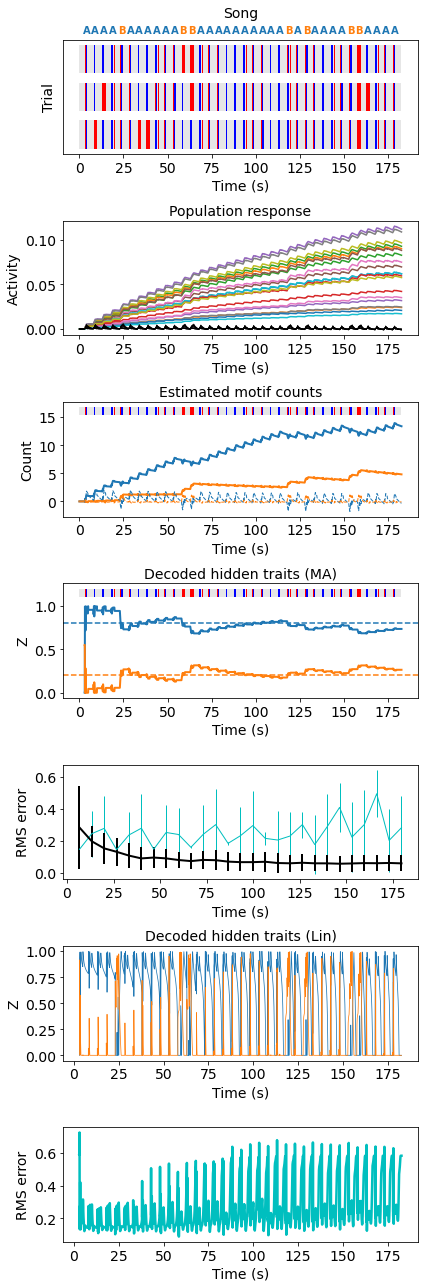

In [33]:
from disp import colors

Z = np.array([.8, .2])  # hidden information

T_PAUSE = 3
T_TOTAL = 180

NTR = 50

fig, axs = plt.subplots(7, 1, figsize=(6, 18), tight_layout=True)

rms_ma_all = []
rms_lin_all = []

for ctr in range(NTR):

    sng, t_sng, t_motifs, imotifs = make_rand_song(Z, motif_basis, T_PAUSE, T_TOTAL)

    i_s = (sng == 1)
    i_p = (sng == 2)

    rs_ma = smlt(i_s, i_p, tau_r, tau_a, x_s, x_p)[0]
    rs_lin = smlt(i_s, i_p, tau_r, tau_a, x_s, x_p, adapt='lin')[0]
    
    # plot song
    if ctr < 3:
        plot_b(axs[0], t_sng, sng, [0, t_sng.max(), -ctr-.25, -ctr-1], c=[(.9, .9, .9), 'b', 'r'])
        set_plot(axs[0], y_label='Activation', title=f'Population response')
    
    if ctr == 0:
        for t_motif, imotif in zip(t_motifs, imotifs):
            axs[0].text(t_motif, 0.05, ['A', 'B'][imotif], color=colors[imotif], ha='center', fontweight='bold')
    
    y_ma = rs_ma@w_ma
    y_lin = rs_lin@w_lin
    
    z_ma = np.clip(y_ma / np.abs(y_ma).sum(1)[:, None], 0, 1)
    z_lin = np.clip(y_lin / np.abs(y_lin).sum(1)[:, None], 0, 1)
    
    rms_ma = np.sqrt(np.mean((z_ma - Z[None, :])**2, axis=1))
    rms_lin = np.sqrt(np.mean((z_lin - Z[None, :])**2, axis=1))
    
    if ctr == 0:
        
        # plot MA responses
        axs[1].plot(t_sng, rs_ma)
        axs[1].plot(t_sng, rs_lin, c='k', lw=.5)

        # plot decoded chirp counts
        for w_ma_, color in zip(w_ma.T, colors):
            axs[2].plot(t_sng, rs_ma@w_ma_, lw=2, c=color)
            
        # plot song
        plot_b(axs[2], t_sng, sng, [0, t_sng.max(), 1.1*np.max(rs_ma@w_ma), 1.2*np.max(rs_ma@w_ma)], c=[(.9, .9, .9), 'b', 'r'])

        for w_lin_, color in zip(w_lin.T, colors):
            axs[2].plot(t_sng, rs_lin@w_lin_, lw=1, c=color, ls='--')

        # plot true Z
        for d, z in enumerate(Z):
            axs[3].axhline(z, color=colors[d], ls='--')
            
        # plot decoded Z
        for d in range(len(Z)):
            axs[3].plot(t_sng, z_ma[:, d], c=colors[d], lw=2)
            axs[5].plot(t_sng, z_lin[:, d], c=colors[d], lw=.75)
            
        plot_b(axs[3], t_sng, sng, [0, t_sng.max(), 1.1*np.nanmax(z_ma), 1.2*np.nanmax(z_ma)], c=[(.9, .9, .9), 'b', 'r'])
            
    rms_ma_all.append(rms_ma.copy())
    rms_lin_all.append(rms_lin.copy())

axs[6].plot(t_sng, np.mean(rms_lin_all, axis=0), c='c', lw=2.5)

step = 200
axs[4].errorbar(t_sng[::step], np.mean(rms_lin_all, axis=0)[::step], yerr=np.std(rms_lin_all, axis=0)[::step], c='c', lw=1)
axs[4].errorbar(t_sng[::step], np.mean(rms_ma_all, axis=0)[::step], yerr=np.std(rms_ma_all, axis=0)[::step], c='k', lw=2)
        
    
set_plot(axs[0], y_ticks=[], y_label='Trial', title='Song\n')
set_plot(axs[1], y_label='Activity', title='Population response')
set_plot(axs[2], y_label='Count', title='Estimated motif counts')
set_plot(axs[3], y_label='Z', title='Decoded hidden traits (MA)')
set_plot(axs[4], y_label='RMS error')
set_plot(axs[5], y_label='Z', title='Decoded hidden traits (Lin)')
set_plot(axs[6], y_label='RMS error')

for ax in axs:
    set_plot(ax, x_label='Time (s)', font_size=14)

fig.savefig('ms/fig_5_social_info_demo.svg')